In [53]:
# Importing libraries

import os, csv, random, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn import datasets
from skrebate import ReliefF
# import scipy.io
# from sklearn import svm
from skfeature.utility.mutual_information import su_calculation
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

random.seed(10)

In [2]:
# path to the data file
path = '../defects/data/Jureczko/augmented_data/ant.csv'

In [3]:
# reading the data
data = pd.read_csv(path)
rows, cols = data.shape
print("Rows:",rows,"\nCols:",cols)

Rows: 2692 
Cols: 21


### Forward Selection

In [10]:
#Forward feature selection
def forwardSelection(X,y):
    gScore = pd.DataFrame(columns=['Number of features','gScore'])
    rows, cols = X.shape
    prevG = 0
    for i in range(cols+1):
        X_sub = X.iloc[:,:i+1]
        #print("Selected ",(i+1)," cols.",X_sub.shape)
        X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.33, random_state=42)
        
        clf = RandomForestClassifier(n_estimators=1000, n_jobs=1)
        clf.fit(X_train, y_train.values.ravel())
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        recall = cm[1][1]/(cm[1][1] + cm[1][0])
        pf = cm[0][1]/(cm[0][1] + cm[0][0])
        #computing the g-score
        g = 2/((1/recall) + (1/(1-pf)))
        delta = g - prevG
        if(delta < 0):
            break
        prevG = g
        gScore.loc[i] = [i+1,g]

    print("Estimated g-Score: ",round(gScore.tail(1).iloc[0,1],4))
    
    plt.plot(gScore['Number of features'],gScore['gScore'])
    plt.xlabel('Number of features')
    plt.ylabel('g Score')
    plt.grid(linewidth = 0.5)
    plt.title("Forward Selection")
    plt.show()
    
    return i


### Backward Elimination

In [11]:
#Backward feature elimination
def backwardElimination(X,y):
    gScore = pd.DataFrame(columns=['Number of features','gScore'])
    rows, cols = X.shape
    prevG = 0
    for i in range(cols-1):
        X_sub = X.iloc[:,0:cols-i]
#         print("Removed ",i," cols.",X_sub.shape)
        X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.33, random_state=42)

        clf = RandomForestClassifier(n_estimators=1000, n_jobs=1)
        clf.fit(X_train, y_train.values.ravel())
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        recall = cm[1][1]/(cm[1][1] + cm[1][0])
        pf = cm[0][1]/(cm[0][1] + cm[0][0])
        #computing the g-score
        g = 2/((1/recall) + (1/(1-pf)))
        delta = g - prevG
        if (delta < 0):
            break
        prevG = g
        gScore.loc[i] = [cols-i,g]
    
    print("Estimated g-Score: ",round(gScore.tail(1).iloc[0,1],4))
    
    plt.plot(gScore['Number of features'],gScore['gScore'])
    plt.xlabel('Number of features')
    plt.ylabel('g Score')
    plt.grid(linewidth = 0.5)
    plt.title("Backward Elimination")
    plt.show()
    
    return i


### Information Gain as feature selector

In [12]:
def infoGain(X, y):
    model = ExtraTreesClassifier()
    model.fit(X, y)
    importance = list(model.feature_importances_)
    features = list(X.columns)
    
    plt.bar(features, importance, align='center', alpha=0.5)
    plt.xlabel('Features')
    plt.xticks(rotation=90)
    plt.ylabel('Feature Importance')
    plt.title('Information Gain')
    plt.show()
    
    thresh = max(importance)/2
    top_feat_idx = [importance.index(i) for i in importance if i >= thresh]
    top_feat = []
    for i in top_feat_idx:
        top_feat.append(features[i])
    return (top_feat)

### Relief-based feature selection using ReliefF

In [23]:
clf = make_pipeline(ReliefF(n_features_to_select=2, n_neighbors=100),
                    RandomForestClassifier(n_estimators=100))

In [26]:
from sklearn.model_selection import cross_val_score
print(np.mean(cross_val_score(clf, X, y)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: All labels are of the same class.

### Principal Component Analysis

In [55]:
# Ref.: https://hub.packtpub.com/4-ways-implement-feature-selection-python-machine-learning/

pca = PCA(n_components=3)
fit = pca.fit(X)
print(fit.explained_variance_ratio_)

print(fit.components_)

[0.7718697  0.19943698 0.0242134 ]
[[ 2.08480764e-02  1.22482731e-04  1.01885694e-04  1.51927513e-02
   6.02377726e-02  5.24866004e-01  9.73575586e-03  6.70333080e-03
   1.44229992e-02 -1.31650260e-04  8.47333868e-01  1.87479904e-04
   1.56554236e-03 -7.15992479e-05 -2.54605261e-04  4.08105603e-04
   6.49997960e-04  4.30353971e-02  6.60243648e-03  6.11311438e-04]
 [ 1.10122414e-02 -1.17253912e-04  6.98785931e-04  2.31083680e-02
   5.40169019e-03  8.45584940e-01  2.38050432e-02  7.40010877e-04
   1.43858584e-02  2.04220015e-04 -5.19373527e-01 -1.51573681e-04
   5.81684247e-04 -3.15933471e-05  1.36802888e-04 -2.83898721e-04
  -6.69103107e-04 -1.17196487e-01 -6.42759813e-03 -9.16329570e-04]
 [-2.05398059e-02 -8.65992141e-04 -8.33795337e-04 -6.04139951e-03
  -6.55034624e-02  8.01500461e-02  2.03189717e-03 -8.29998028e-03
  -1.12605102e-02  7.58340848e-04 -9.43161993e-02 -5.69890271e-04
  -1.63958969e-03 -4.33937035e-05  1.37673776e-04 -7.80178961e-04
  -1.58765354e-03  9.89742845e-01 -1.14

### CFS

In [83]:
def merit_calculation(X, y):
    """
    This function calculates the merit of X given class labels y, where
    merits = (k * rcf)/sqrt(k+k*(k-1)*rff)
    rcf = (1/k)*sum(su(fi,y)) for all fi in X
    rff = (1/(k*(k-1)))*sum(su(fi,fj)) for all fi and fj in X
    Input
    ----------
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ----------
    merits: {float}
        merit of a feature subset X
    """

    n_samples, n_features = X.shape
    rff = 0
    rcf = 0
    for i in range(n_features):
        fi = X.iloc[:, i]
        rcf += su_calculation(fi, y)
        for j in range(n_features):
            if j > i:
                fj = X.iloc[:, j]
                rff += su_calculation(fi, fj)
    rff *= 2
    merits = rcf / np.sqrt(n_features + rff)
    return merits


def cfs(X, y):
    """
    This function uses a correlation based heuristic to evaluate the worth of features which is called CFS
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    F: {numpy array}
        index of selected features
    Reference
    ---------
    Zhao, Zheng et al. "Advancing Feature Selection Research - ASU Feature Selection Repository" 2010.
    """

    n_samples, n_features = X.shape
    F = []
    # M stores the merit values
    M = []
    while True:
        merit = -100000000000
        idx = -1
        for i in range(n_features):
            if i not in F:
                F.append(i)
                # calculate the merit of current selected features
                t = merit_calculation(X.iloc[:, F], y)
                if t > merit:
                    merit = t
                    idx = i
                F.pop()
        F.append(idx)
        M.append(merit)
        if len(M) > 5:
            if M[len(M)-1] <= M[len(M)-2]:
                if M[len(M)-2] <= M[len(M)-3]:
                    if M[len(M)-3] <= M[len(M)-4]:
                        if M[len(M)-4] <= M[len(M)-5]:
                            break
    return np.array(F)

def correlationBased(X,y):
    n_samples, n_features = X.shape    
    num_fea = 20
    idx = cfs(X,y)
    selected_features = X.iloc[:, idx[0:num_fea]]
    return (selected_features.columns)

## Performing feature selection

In [87]:
def featureSelection(type, X, y):
    
    if (type == 'forward'):
        val = forwardSelection(X,y)
        sel_feat = list(X.columns[:val])
    elif (type == 'backward'):
        val = backwardElimination(X,y)
        sel_feat = list(X.columns[cols-val-1:])
    elif (type == 'infogain'):
        sel_feat = infoGain(X,y)
    elif (type == 'cfs'):
        sel_feat = correlationBased(X,y)
        
    print(sel_feat)
    

In [8]:
X = data.loc[:,data.columns!='$<bug']
y = data.loc[:,data.columns=='$<bug']  

Estimated g-Score:  0.7332


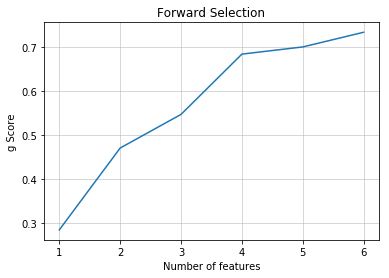

['$wmc', '$dit', '$noc', '$cbo', '$rfc', '$lcom']


In [18]:
featureSelection('forward',X,y)

Estimated g-Score:  0.7231


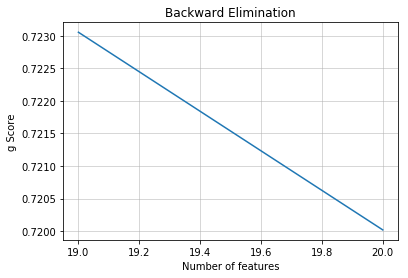

['$max_cc', '$avg_cc']


In [19]:
featureSelection('backward',X,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


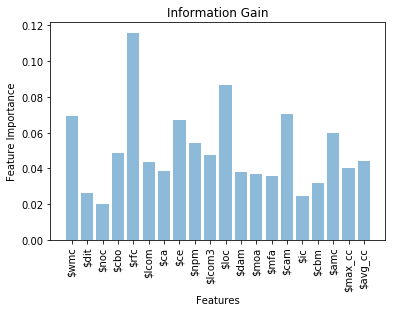

['$wmc', '$rfc', '$ce', '$loc', '$cam', '$amc']


In [85]:
featureSelection('infogain',X,y)

In [88]:
featureSelection('cfs',X,y)

Index(['$wmc', '$dit', '$noc', '$moa', '$ic', '$max_cc', '$ca', '$ce', '$dam',
       '$cbm', '$cbo', '$npm', '$rfc', '$lcom', '$avg_cc'],
      dtype='object')
